In [1]:
from __future__ import print_function
import numpy as np
import os
import sys
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
# Download the original SVHN dataset in compressed .tar.gz format.
# These contain varying-resolution images (in .png) with multi-digit labels of a number sequence for each image.
# Also contains a digitStruct.mat file which stores image name, positions, size, and label of the bounding boxes per digit.
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
    last_percent_reported = percent

def maybe_download(filename, force=False):
    # Download a file if not present
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
        statinfo = os.stat(filename)
        return filename
    else:
        print(filename + ' has already been downloaded!')

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')
extra_filename = maybe_download('extra.tar.gz')

train.tar.gz has already been downloaded!
test.tar.gz has already been downloaded!
extra.tar.gz has already been downloaded!


In [7]:
# Extract downloaded .tar.gz files
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # Remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = root
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract('train.tar.gz')
test_folders = maybe_extract('test.tar.gz')
extra_folders = maybe_extract('extra.tar.gz')

train already present - Skipping extraction of train.tar.gz.
train
test already present - Skipping extraction of test.tar.gz.
test
extra already present - Skipping extraction of extra.tar.gz.
extra


In [8]:
# Helper function to extract data from the DigiStruct file into a Python dictionary.
# Ref: https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657/5

import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [9]:
# Run the DigitStructFile function for train, test and extra datasets.

def run_DSF(folder_name):
    path = os.path.join(folder_name, 'digitStruct.mat')
    dsf = DigitStructFile(path)
    print("Extracting data from %s. This may take a while. Please wait." % path)
    dataset = dsf.getAllDigitStructure_ByDigit()
    return dataset


train_data = run_DSF('train')
test_data = run_DSF('test')
extra_data = run_DSF('extra')

print("Complete!")

Extracting data from train/digitStruct.mat. This may take a while. Please wait.
Extracting data from test/digitStruct.mat. This may take a while. Please wait.
Extracting data from extra/digitStruct.mat. This may take a while. Please wait.
Complete!


In [10]:
# Save to pickle file for later reuse.

pickle_file = 'SVHN_multi_exp.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_dataset': train_data,
    'test_dataset': test_data,
    'extra_dataset': extra_data
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 85307187


In [2]:
# Load pickle file of preprocessed dataset

pickle_file = 'SVHN_multi_exp.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    test_dataset = save['test_dataset']
    extra_dataset = save['extra_dataset']
    del save  # Hint to help gc free up memory

print('Train set', len(train_dataset))
print('Test set', len(test_dataset))
print('Extra set', len(extra_dataset))

Train set 33402
Test set 13068
Extra set 202353


In [3]:
dataset=np.concatenate((
        train_dataset,
        test_dataset,
        extra_dataset))

print("Total dataset dimensions:",len(dataset))

Total dataset dimensions: 248823


In [4]:
print(train_dataset[0])

{'boxes': [{'height': 219.0, 'width': 81.0, 'top': 77.0, 'left': 246.0, 'label': 1.0}, {'height': 219.0, 'width': 96.0, 'top': 81.0, 'left': 323.0, 'label': 9.0}], 'filename': '1.png'}


In [35]:
from collections import Counter

label_list = []

for row in range(len(dataset)):
    for boxes in dataset[row]['boxes']:
        if boxes['label'] == 10.0:
            boxes['label'] = 0.0 # Encode 10 as digit label '0'
        label_list.append(boxes['label'])

c = Counter(label_list)
print(c)

Counter({1.0: 109520, 2.0: 89474, 3.0: 72144, 5.0: 62756, 4.0: 60614, 0.0: 52242, 7.0: 51611, 6.0: 49286, 8.0: 42063, 9.0: 40710})


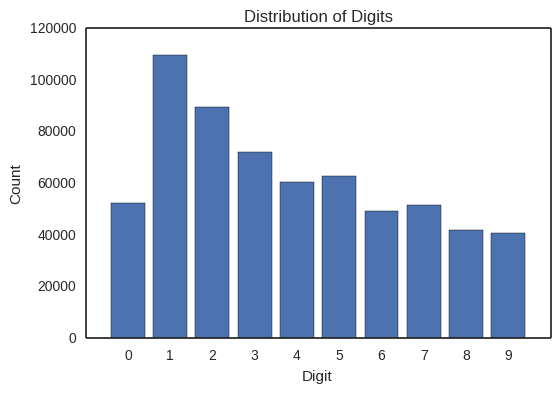

In [78]:
sns.set_style("white")
plt.bar(c.keys(), c.values(), align="center")
plt.xticks(c.keys())
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Distribution of Digits')
plt.xlim([-1, 10])
plt.show()